# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

## Install `tsfm`
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [11]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /tmp/pip-install-hpxl41yq/tsfm-public_9d2b68ebce4f430b9d3489f453536330
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-hpxl41yq/tsfm-public_9d2b68ebce4f430b9d3489f453536330
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [ ]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [ ]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [ ]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

## Zero-shot evaluation method

In [ ]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)

    # Load model
    zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-46241:t-23415156142848:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-46241:t-23415156142848:get_model.py:get_model:Selected TTM `prediction_length` = 96
INFO:p-46241:t-23415156142848:get_model.py:get_model:Model loaded successfully!
INFO:p-46241:t-23415156142848:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3628121316432953, 'eval_model_preparation_time': 0.002, 'eval_runtime': 2.6144, 'eval_samples_per_second': 1065.24, 'eval_steps_per_second': 16.83}
(2785, 96, 7)
(2785, 7, 8, 192)


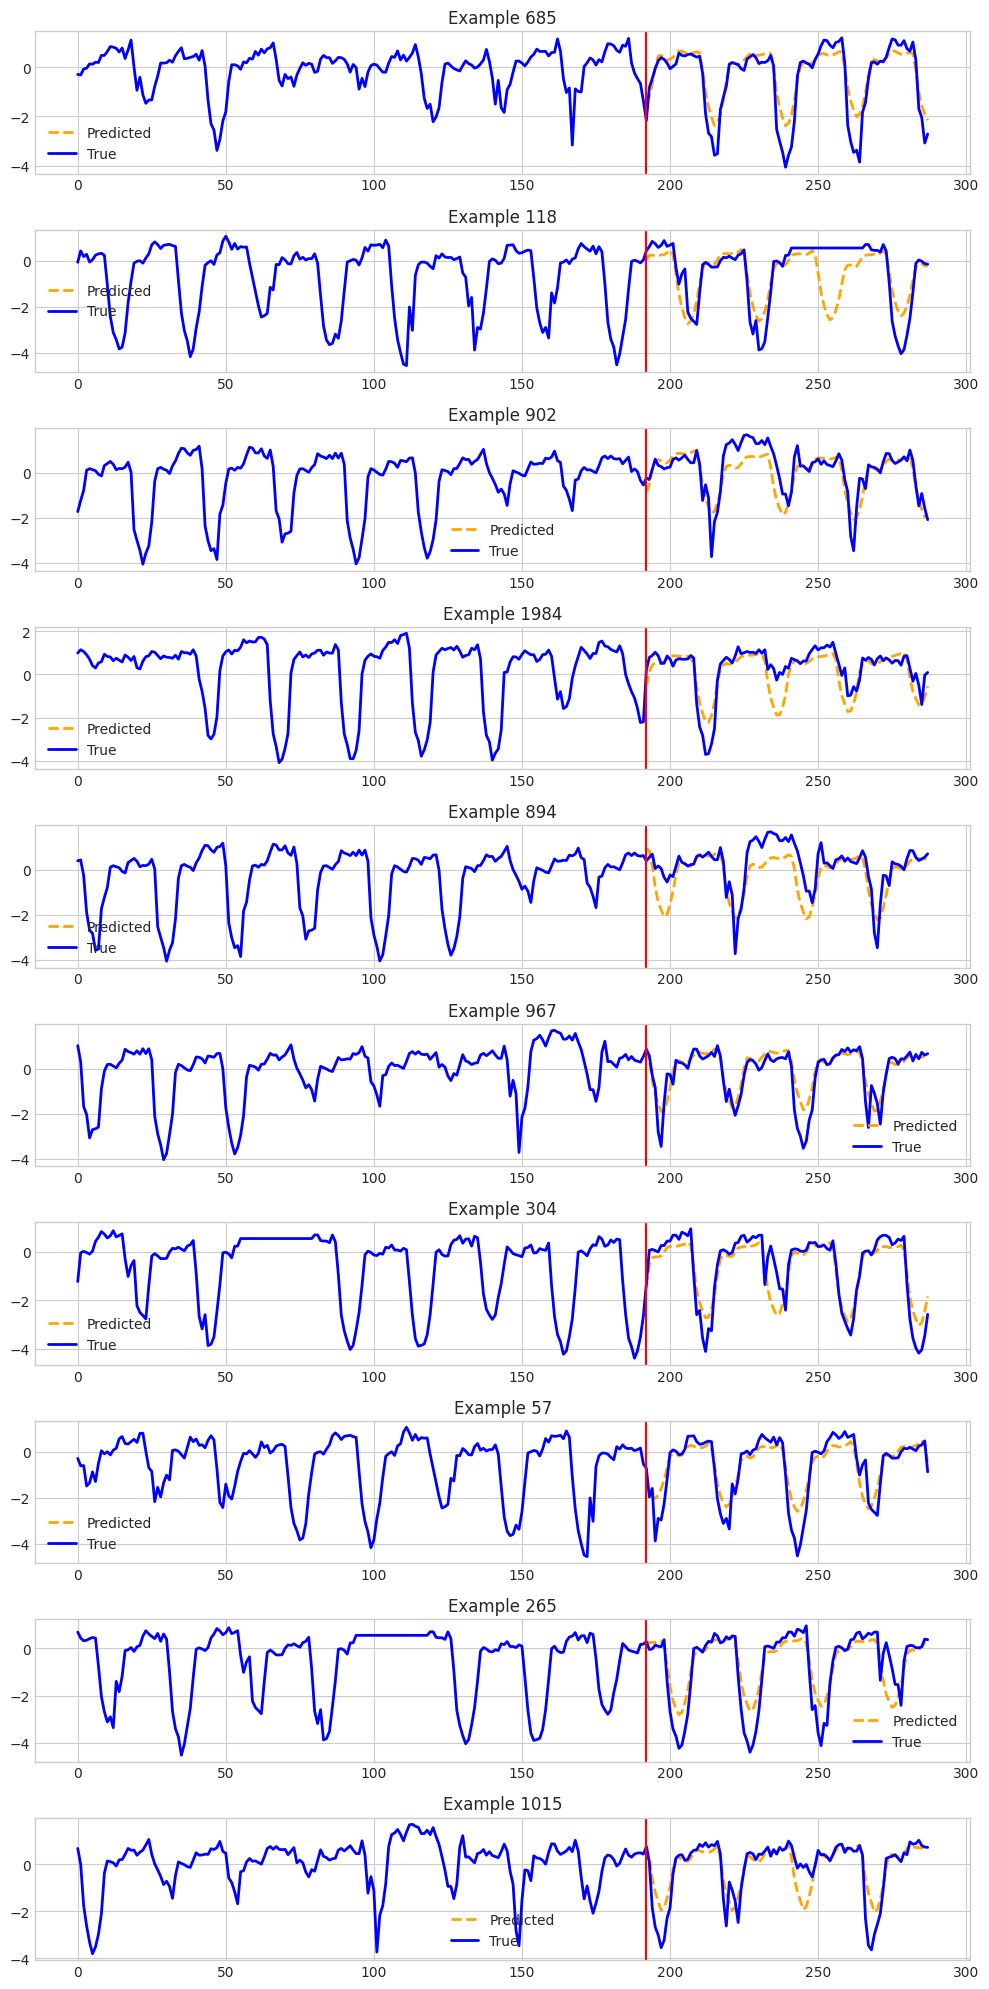

In [ ]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [ ]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            loss=loss,
            quantile=quantile,
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.860300,0.664148
2,0.804900,0.663823
3,0.781000,0.663180
4,0.743000,0.662238
5,0.707200,0.661821
6,0.684400,0.661966
7,0.652300,0.664294
8,0.626900,0.673325
9,0.610100,0.690535
10,0.590600,0.708973


[TrackingCallback] Mean Epoch Time = 3.4508862018585207 seconds, Total Train Time = 331.21193170547485
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36163726449012756, 'eval_runtime': 16.9844, 'eval_samples_per_second': 163.974, 'eval_steps_per_second': 2.591, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


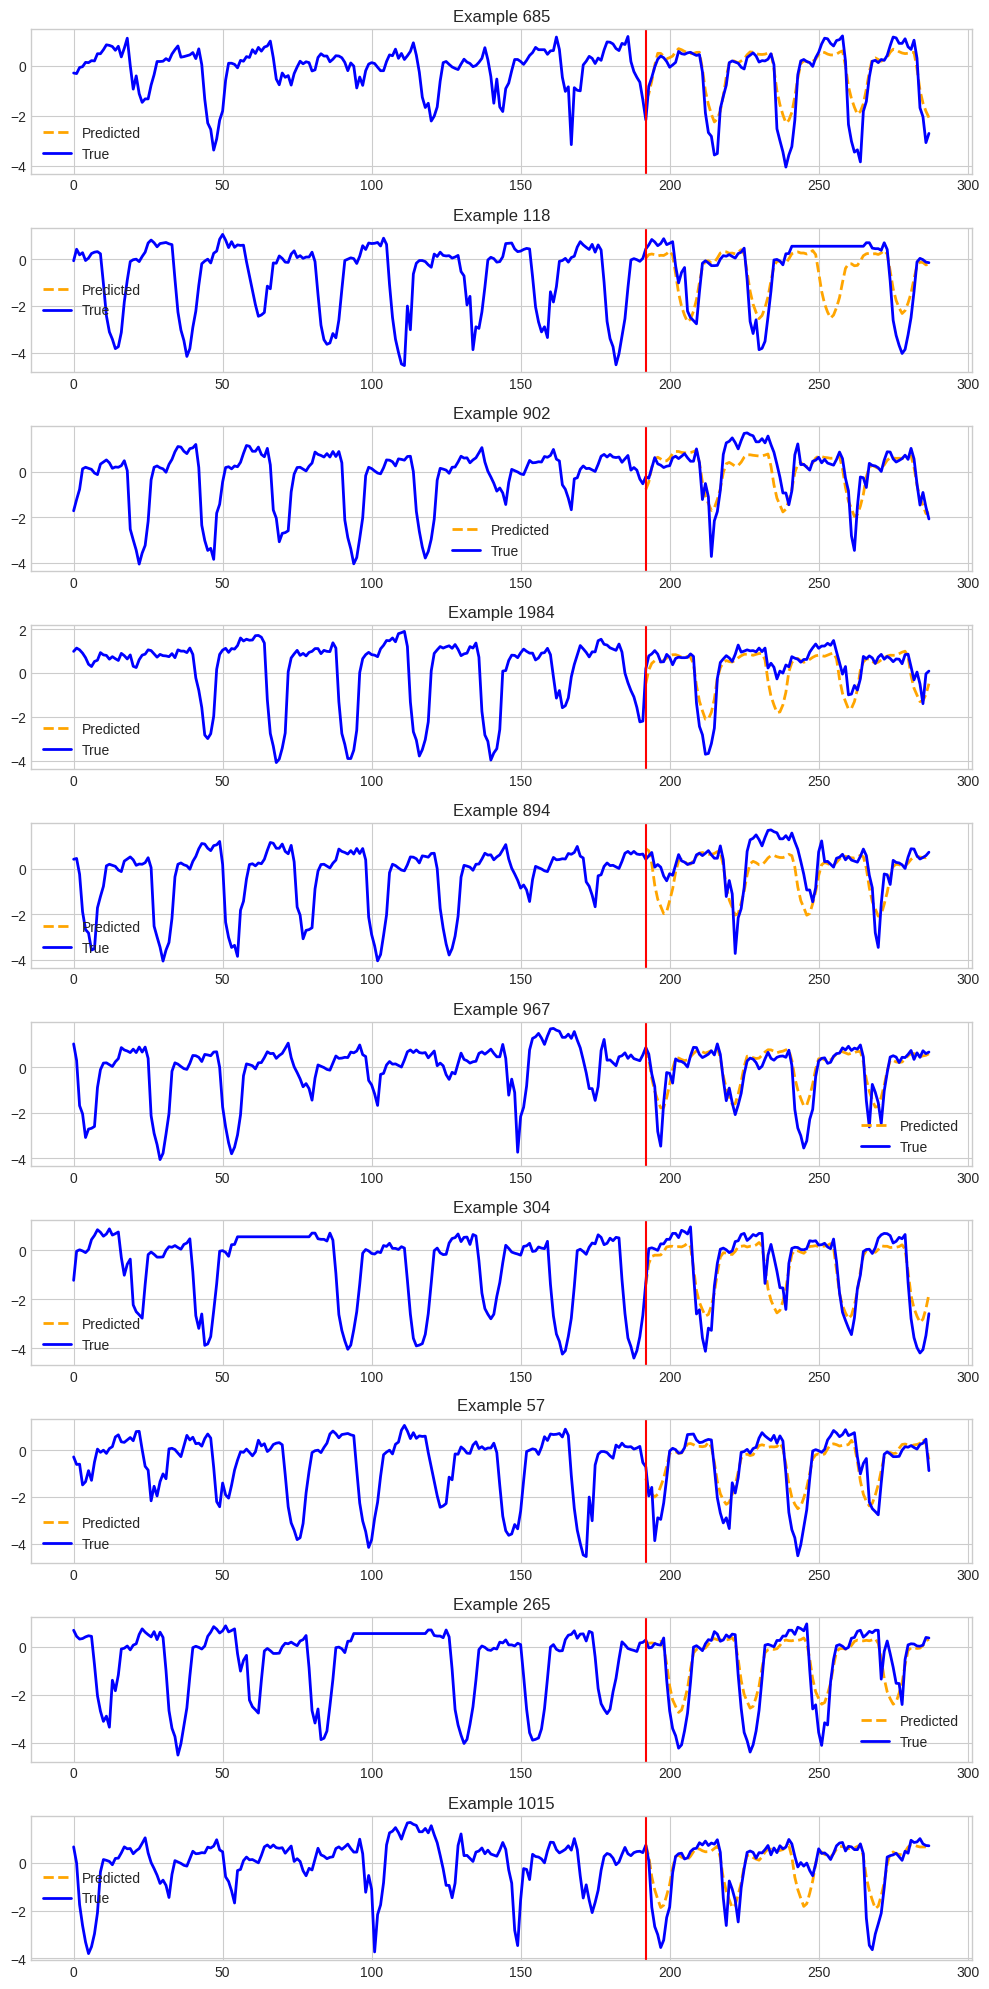

In [9]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.331800,0.273076
2,0.324900,0.273046
3,0.320500,0.273010
4,0.315500,0.273076
5,0.306900,0.273386
6,0.303200,0.273877
7,0.298200,0.275350
8,0.293300,0.278550
9,0.290500,0.284549
10,0.285200,0.289772


[TrackingCallback] Mean Epoch Time = 3.3668122658362756 seconds, Total Train Time = 290.48233938217163
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36184385418891907, 'eval_runtime': 16.6085, 'eval_samples_per_second': 167.686, 'eval_steps_per_second': 2.649, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


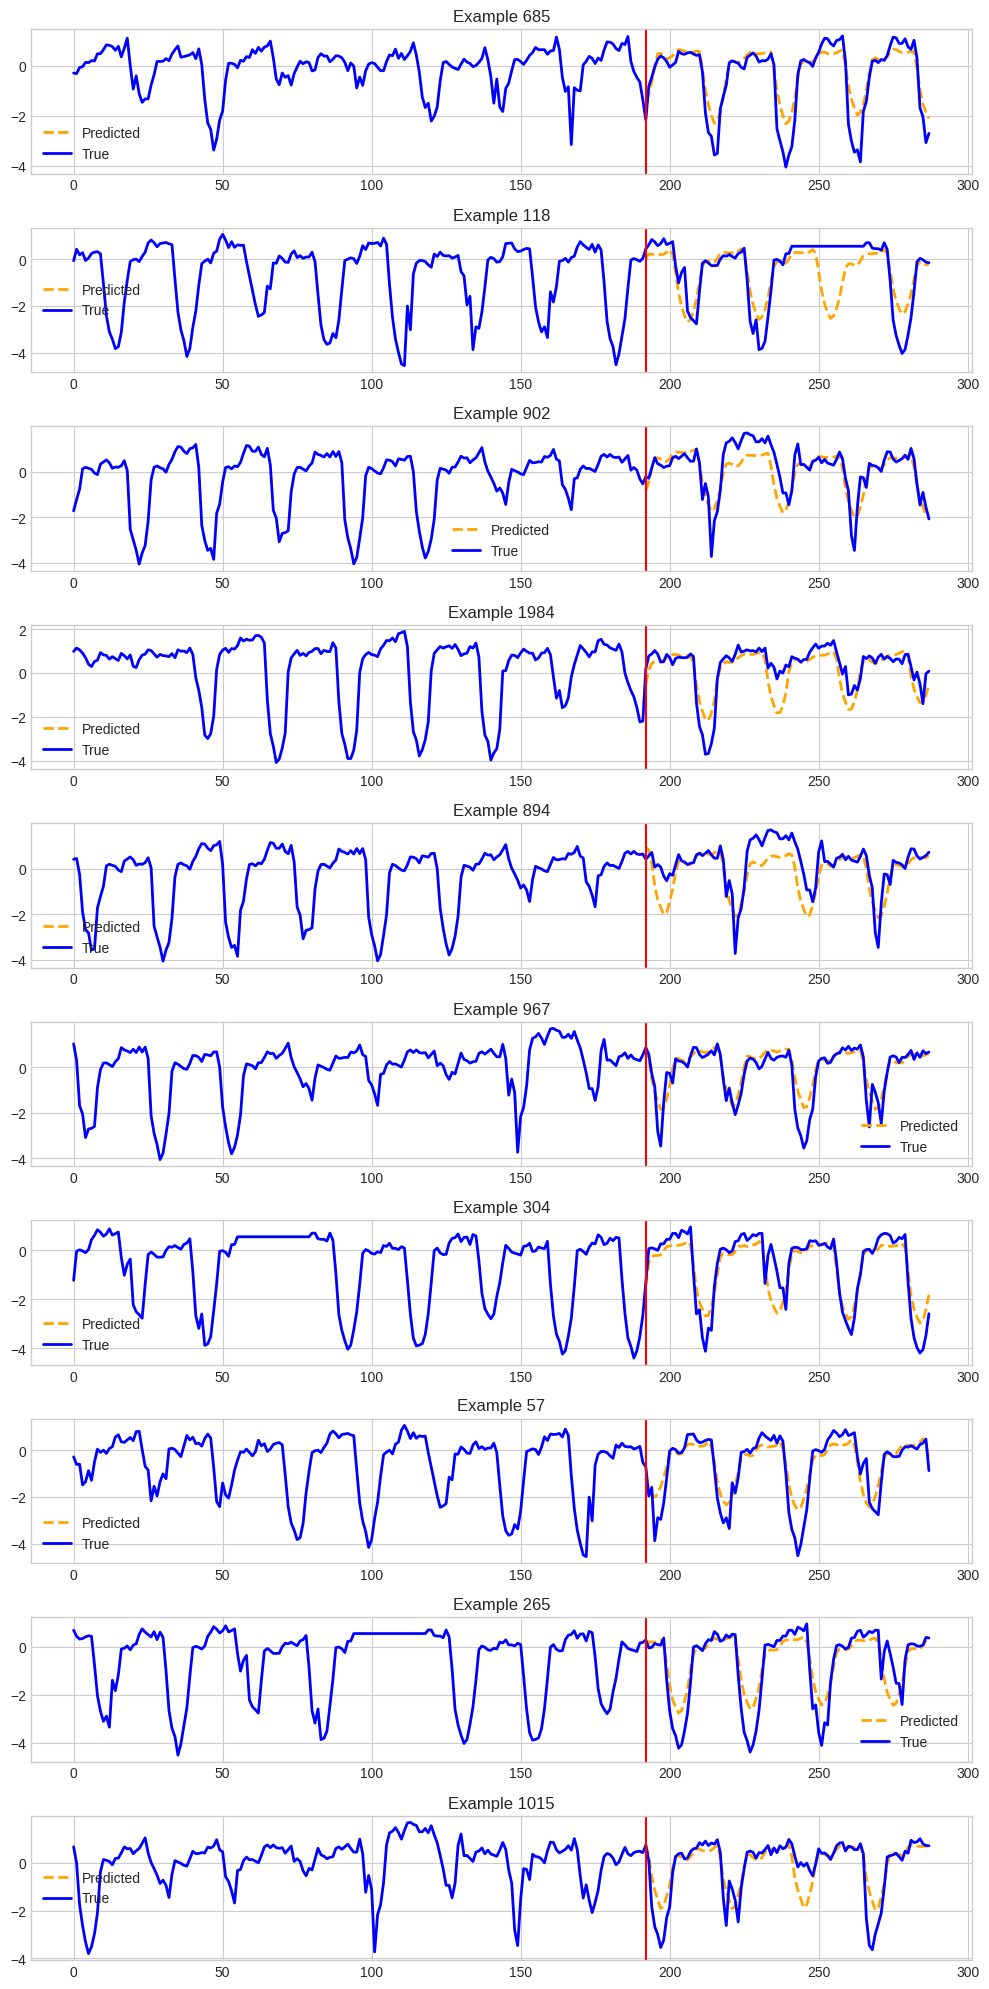

In [10]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths


**Context length, Or Length of the history:** Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1

**Forecast length, Or prediction length:** Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96




### Zero-shot

INFO:p-1598345:t-23063713661696:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-1598345:t-23063713661696:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}
INFO:p-1598345:t-23063713661696:get_model.py:get_model:Model loaded successfully!
INFO:p-1598345:t-23063713661696:get_model.py:get_model:[TTM] context_len = 1024, forecast_len = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.33274462819099426, 'eval_model_preparation_time': 0.0019, 'eval_runtime': 0.7548, 'eval_samples_per_second': 3753.1, 'eval_steps_per_second': 59.615}
(2833, 48, 7)
(2833, 7, 8, 384)


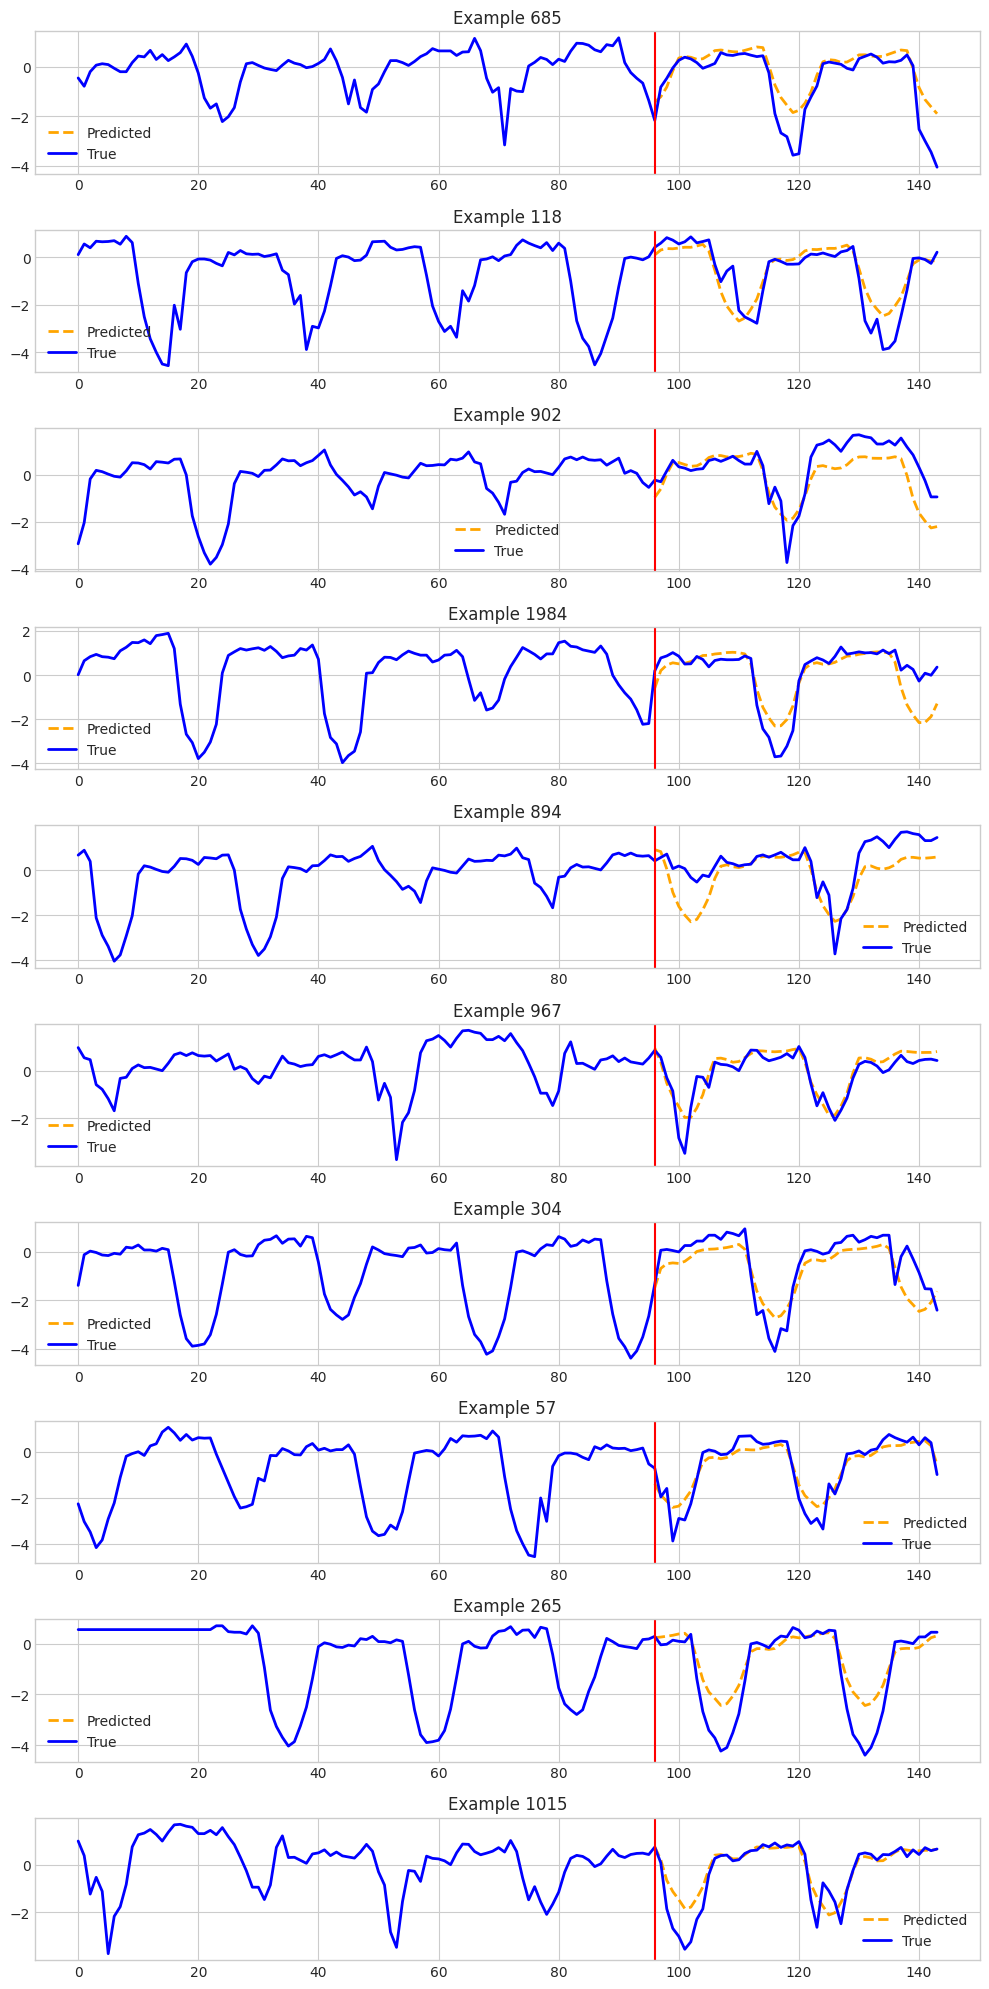

In [ ]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-1598345:t-23063713661696:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-1598345:t-23063713661696:get_model.py:get_model:Selected prediction_length = 96
                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}


-------------------- Running few-shot 5% --------------------


INFO:p-1598345:t-23063713661696:get_model.py:get_model:Model loaded successfully!
INFO:p-1598345:t-23063713661696:get_model.py:get_model:[TTM] context_len = 1536, forecast_len = 96
INFO:p-1598345:t-23063713661696:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-1598345:t-23063713661696:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.


Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560


INFO:p-1598345:t-23063713661696:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.00035938136638046257


OPTIMAL SUGGESTED LEARNING RATE = 0.00035938136638046257
Using learning rate = 0.00035938136638046257


Epoch,Training Loss,Validation Loss
1,0.558300,0.504625
2,0.522800,0.505693
3,0.492200,0.506962
4,0.483700,0.508520
5,0.397600,0.510497
6,0.323300,0.514045
7,0.345200,0.525361
8,0.280800,0.541317
9,0.238600,0.550981
10,0.221500,0.592485


[TrackingCallback] Mean Epoch Time = 0.5496336763555353 seconds, Total Train Time = 17.354819536209106
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.32994189858436584, 'eval_runtime': 0.8224, 'eval_samples_per_second': 3444.711, 'eval_steps_per_second': 54.717, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2833, 48, 7)
(2833, 7, 12, 384)


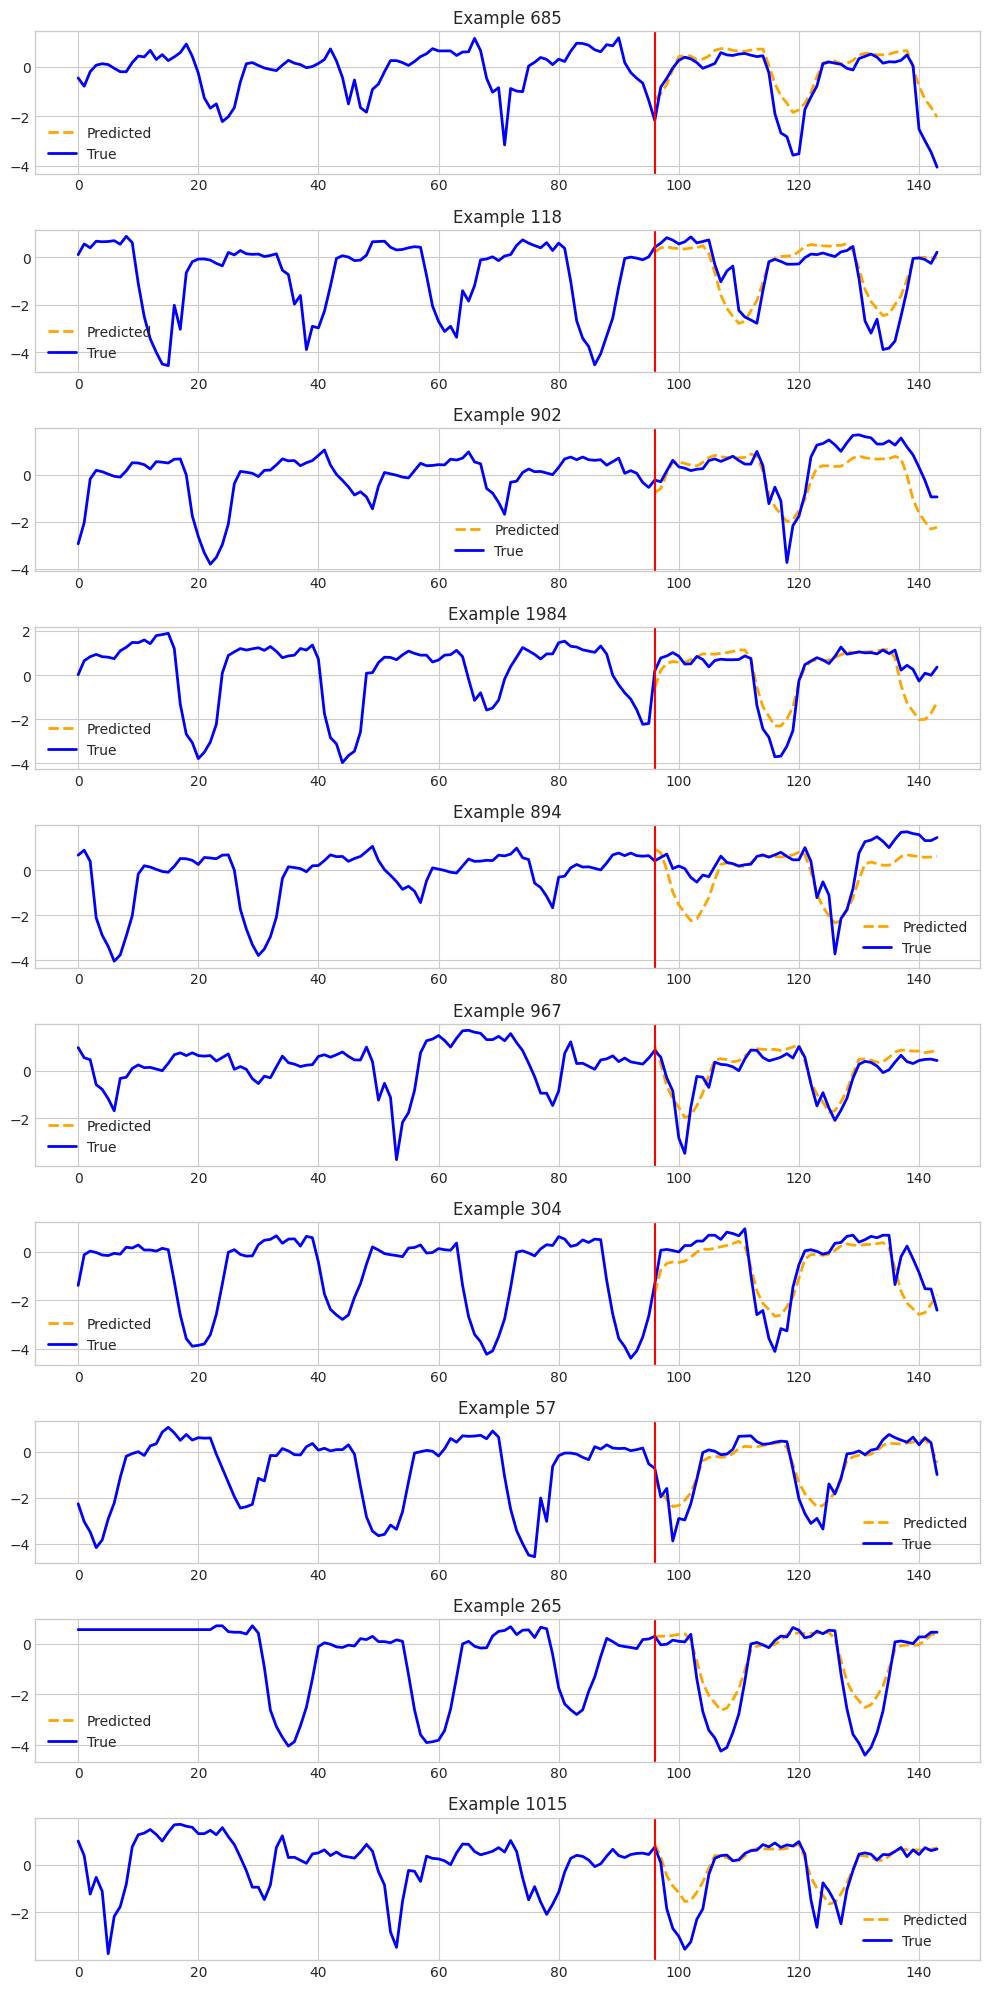

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)